## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Load Dataset

In [3]:
df = pd.read_csv('ACRX.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-02-11,5.00,5.09,4.51,4.55,4.55,1899700
1,2011-02-14,4.53,4.73,4.35,4.38,4.38,66300
2,2011-02-15,4.50,4.50,4.08,4.31,4.31,37400
3,2011-02-16,4.37,4.37,4.15,4.24,4.24,9500
4,2011-02-17,4.14,4.22,3.85,3.85,3.85,60000
...,...,...,...,...,...,...,...
2294,2020-03-26,1.30,1.46,1.21,1.32,1.32,2487700
2295,2020-03-27,1.30,1.32,1.12,1.27,1.27,1068400
2296,2020-03-30,1.25,1.29,1.23,1.27,1.27,710200
2297,2020-03-31,1.26,1.26,1.11,1.18,1.18,701500


In [4]:
df = df[['Date', 'Open']]
df

,Date,Open
0,2011-02-11,5.00
1,2011-02-14,4.53
2,2011-02-15,4.50
3,2011-02-16,4.37
4,2011-02-17,4.14
...,...,...
2294,2020-03-26,1.30
2295,2020-03-27,1.30
2296,2020-03-30,1.25
2297,2020-03-31,1.26


## Preprocessing Data

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_24908\1894350371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\DELL\AppData\Local\Temp\ipykernel_24908\1894350371.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('Date', inplace=True)


In [6]:
# Chia dữ liệu thành tập train và tập test
split_date = '2019-01-01' 
train_data = df[df['Date'] < split_date]
test_data = df[df['Date'] >= split_date]

In [7]:
training_set = train_data.iloc[:, 1].values.reshape(-1, 1)
testing_set = test_data.iloc[:, 1].values.reshape(-1, 1)
training_set

array([[5.        ],
       [4.53000021],
       [4.5       ],
       ...,
       [2.18000007],
       [2.43000007],
       [2.3499999 ]])

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set)

In [25]:
X_train = []
y_train = []
X_test = []
y_test = []
lookback = 7

for i in range(lookback, len(training_set)):
    X_train.append(training_set_scaled[i-lookback:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
for i in range(lookback, len(testing_set)):
    X_test.append(testing_set_scaled[i-lookback:i, 0])
    y_test.append(testing_set_scaled[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test)
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(1977, 7)
(1977,)


In [26]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

# Conver to tensor
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1977, 7, 1]),
 torch.Size([1977, 1]),
 torch.Size([308, 7, 1]),
 torch.Size([308, 1]))

In [27]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [28]:
from torch.utils.data import DataLoader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out

model = BiLSTM(1, 4, 2)
model.to(device)
model

BiLSTM(
  (lstm): LSTM(1, 4, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [30]:
learning_rate = 0.001
num_epochs = 5
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

In [31]:
for epoch in range(num_epochs):
        model.train(True)
        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_index % 10 == 0:
                print(f'Epoch: {epoch + 1} Batch: {batch_index} Loss: {loss.item():.3f}')

Epoch: 1 Batch: 0 Loss: 0.428
Epoch: 1 Batch: 10 Loss: 0.334
Epoch: 1 Batch: 20 Loss: 0.377
Epoch: 1 Batch: 30 Loss: 0.197
Epoch: 1 Batch: 40 Loss: 0.338
Epoch: 1 Batch: 50 Loss: 0.243
Epoch: 1 Batch: 60 Loss: 0.203
Epoch: 1 Batch: 70 Loss: 0.213
Epoch: 1 Batch: 80 Loss: 0.187
Epoch: 1 Batch: 90 Loss: 0.241
Epoch: 1 Batch: 100 Loss: 0.036
Epoch: 1 Batch: 110 Loss: 0.043
Epoch: 1 Batch: 120 Loss: 0.173
Epoch: 2 Batch: 0 Loss: 0.118
Epoch: 2 Batch: 10 Loss: 0.041
Epoch: 2 Batch: 20 Loss: 0.060
Epoch: 2 Batch: 30 Loss: 0.131
Epoch: 2 Batch: 40 Loss: 0.039
Epoch: 2 Batch: 50 Loss: 0.035
Epoch: 2 Batch: 60 Loss: 0.086
Epoch: 2 Batch: 70 Loss: 0.060
Epoch: 2 Batch: 80 Loss: 0.075
Epoch: 2 Batch: 90 Loss: 0.034
Epoch: 2 Batch: 100 Loss: 0.060
Epoch: 2 Batch: 110 Loss: 0.042
Epoch: 2 Batch: 120 Loss: 0.053
Epoch: 3 Batch: 0 Loss: 0.055
Epoch: 3 Batch: 10 Loss: 0.040
Epoch: 3 Batch: 20 Loss: 0.036
Epoch: 3 Batch: 30 Loss: 0.025
Epoch: 3 Batch: 40 Loss: 0.030
Epoch: 3 Batch: 50 Loss: 0.016
Epoch

In [32]:
model.eval()
predict_stock_price = []
for batch_index, batch in enumerate(test_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        predict = model(X_batch)
        predict_stock_price.append(predict)
        loss = loss_function(predict, y_batch)
        print(f"Batch index: {batch_index} | Test loss: {loss.item():.3f}")        
# predict_stock_price

Batch index: 0 | Test loss: 0.000
Batch index: 1 | Test loss: 0.000
Batch index: 2 | Test loss: 0.001
Batch index: 3 | Test loss: 0.000
Batch index: 4 | Test loss: 0.000
Batch index: 5 | Test loss: 0.000
Batch index: 6 | Test loss: 0.001
Batch index: 7 | Test loss: 0.000
Batch index: 8 | Test loss: 0.000
Batch index: 9 | Test loss: 0.001
Batch index: 10 | Test loss: 0.000
Batch index: 11 | Test loss: 0.001
Batch index: 12 | Test loss: 0.001
Batch index: 13 | Test loss: 0.002
Batch index: 14 | Test loss: 0.001
Batch index: 15 | Test loss: 0.001
Batch index: 16 | Test loss: 0.002
Batch index: 17 | Test loss: 0.003
Batch index: 18 | Test loss: 0.005
Batch index: 19 | Test loss: 0.003


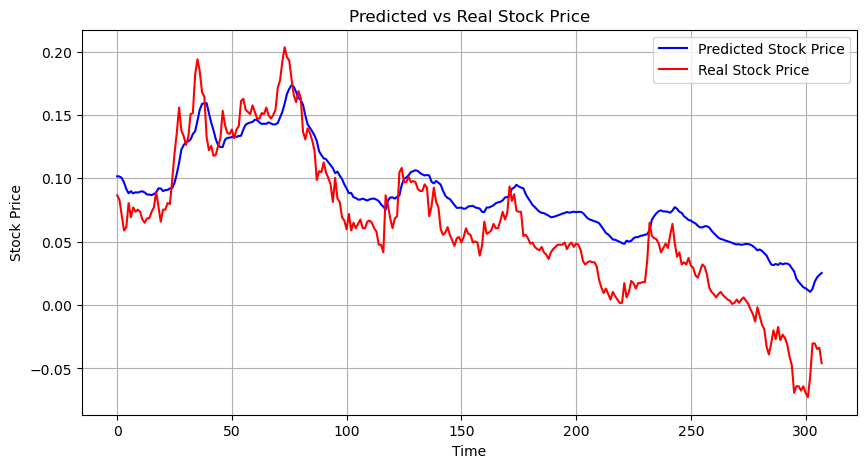

In [33]:
model.eval()
predict_stock_price = []

for batch_index, batch in enumerate(test_loader):
    X_batch, y_batch = batch[0].to(device), batch[1].to(device)
    with torch.no_grad():
        predict = model(X_batch)
        predict_stock_price.append(predict.cpu().numpy())

# Flatten the list of arrays into a single numpy array
predict_stock_price = np.concatenate(predict_stock_price)

# Reshape the real_stock_price to match the shape of predict_stock_price
real_stock_price = testing_set_scaled[lookback:]

# Tạo mảng chỉ số thời gian tương ứng với các dự đoán và giá thực tế
time_index = np.arange(len(predict_stock_price))

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
plt.plot(time_index, predict_stock_price, label='Predicted Stock Price', color='blue')
plt.plot(time_index, real_stock_price, label='Real Stock Price', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Predicted vs Real Stock Price')
plt.legend()
plt.grid(True)
plt.show()
